## Sentiment Analysis Using Logistic Regression



In [51]:
#load necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [52]:
#Read Dataset
df=pd.read_csv("sentiment.csv")
df.head()

,Phrase,label
0,Spider-man is better than any summer blockbust...,Positive
1,of good sense,Positive
2,", then knock yourself out and enjoy the big sc...",Negative
3,So could young romantics out on a date .,Positive
4,humour,Positive


In [53]:
df.shape

(2800, 2)

This dataset has 2800 rows and 2 columns. 

In [54]:
len(df[df['label']=='Positive']) #total number of positive class

1800

In [55]:
len(df[df['label']=='Negative']) #total number of negative class

1000

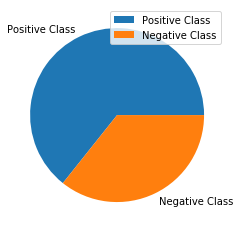

In [56]:
plt.pie(x=[len(df[df['label']=='Positive']),len(df[df['label']=='Negative'])],labels=["Positive Class","Negative Class"])
plt.legend()

The number of positive class is quite larger than number of negative class examples. 

## Vectorization of Phrase

In [57]:
total_len=len(df)
train_len=int(0.6*total_len)
val_len=int(0.2*total_len)
test_len=int(0.2*total_len)
print("total=> {} train_len=> {} val_len=> {} test_len =>{}".format(total_len,train_len,val_len,test_len))

total=> 2800 train_len=> 1680 val_len=> 560 test_len =>560


**Split dataset into train, val and test set**

In [58]:
train_df=df[0:train_len]
val_df=df[train_len:train_len+val_len]
test_df=df[train_len+val_len:]

In [59]:
print("Length of train dataset, validation dataset and test dataset")
print("train_df_len=> {} val_df_len=> {} test_df_len =>{}".format(len(train_df),len(val_df),len(test_df)))

Length of train dataset, validation dataset and test dataset
train_df_len=> 1680 val_df_len=> 560 test_df_len =>560


In [60]:
vocab=list()
#create a corpus of vocab
for i in train_df.Phrase.tolist():
    vocab.extend(i.split(" "))
    
#take unique words from vocab   
unique_vocab=list(set(vocab)) #set can't be indexed so change it to list for simplicity    

In [61]:
print("Vocab Length => {} Unique Vocab Length => {}".format(len(vocab),len(unique_vocab)))

Vocab Length => 13855 Unique Vocab Length => 1844


## Feature_Extraction

In [62]:
def extract_feature(unique_vocab,dataset):

    feature=[]
    label=[]
    for index,row in dataset.iterrows():
        words=row["Phrase"].split(" ") 
        f=[]
        for v in unique_vocab:
            if v in words:
                f.append(1)
            else:
                f.append(0)
                
        if row["label"]=="Positive":
            label.append(1)
        elif row["label"]=="Negative":
            label.append(0)

        feature.append(f)
    
    #change features and label list into numpy array
    feature=np.array(feature)
    label=np.array(label) 
    #change label into 2D
    label=label.reshape(-1,1)
    print(feature)
    
    return feature,label 

**create train, val and test set feature and labels**

In [63]:
X_train,y_train=extract_feature(unique_vocab,train_df)
X_val,y_val=extract_feature(unique_vocab,val_df)
X_test,y_test=extract_feature(unique_vocab,test_df)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [64]:
X_train.shape

(1680, 1844)

**Add bias to X**

In [65]:
X_train=np.insert(X_train,0,values=1,axis=1)
X_val=np.insert(X_val,0,values=1,axis=1)
X_test=np.insert(X_test,0,values=1,axis=1)

In [66]:
X_val

array([[1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0]])

## Build Model

In [67]:
np.random.seed(42)
params={
    "num_of_iterations": 1000,
    "learning_rate": 0.0001
}

grid_param={
    "num_of_iteration":[1000,1500,2000],
    "learning_rate":[0.001,0.1,0.01]
}

In [68]:
#Binary Cross Entropy Loss
def bce_loss(h,y):
    m=len(h)
    return -np.average(y*np.log(h)+(1-y)*np.log(1-h))

In [69]:
#Sigmoid function
def sigmoid(x):
    return 1/(1+np.exp(-x))
    

In [70]:
#train model 
def train_model(X_train,y_train, X_val, y_val, param):
    W=np.random.rand(X_train.shape[1]).reshape(-1,1)
    train_error=[]
    for i in range(1,param["num_of_iterations"]):
        h_train=sigmoid(np.matmul(X_train,W))
        train_loss=bce_loss(h_train,y_train)
        
        train_error.append(train_loss)
        
        gradient=(np.matmul(np.transpose(X_train),(h_train-y_train)))/X_train.shape[0]
        W-=params["learning_rate"]*gradient
        
    h_val=sigmoid(np.matmul(X_val,W))
    val_loss=bce_loss(h_val,y_val)        
    print(param,val_loss)
    return W,train_error

**Grid Search**

In [71]:
import itertools
grid=list(itertools.product(grid_param["num_of_iteration"],grid_param["learning_rate"]))
grid

[(1000, 0.001),
 (1000, 0.1),
 (1000, 0.01),
 (1500, 0.001),
 (1500, 0.1),
 (1500, 0.01),
 (2000, 0.001),
 (2000, 0.1),
 (2000, 0.01)]

In [72]:
for g in grid:
    p={
        'num_of_iterations':g[0],
        'learning_rate':g[1]
    }
    train_model(X_train,y_train,X_val,y_val,p)

{'num_of_iterations': 1000, 'learning_rate': 0.001} 1.4660697318435085
{'num_of_iterations': 1000, 'learning_rate': 0.1} 1.3775594217176628
{'num_of_iterations': 1000, 'learning_rate': 0.01} 1.4465035610805153
{'num_of_iterations': 1500, 'learning_rate': 0.001} 1.3868275750793828
{'num_of_iterations': 1500, 'learning_rate': 0.1} 1.422391003802561
{'num_of_iterations': 1500, 'learning_rate': 0.01} 1.5988486708057523
{'num_of_iterations': 2000, 'learning_rate': 0.001} 1.43975755994022
{'num_of_iterations': 2000, 'learning_rate': 0.1} 1.480663731470894
{'num_of_iterations': 2000, 'learning_rate': 0.01} 1.5435925427674941


**Train Loss Plot for Best Model**

In [73]:
params={
    'num_of_iterations':1000,
    'learning_rate':0.1
}
final_weights,train_loss=train_model(X_train,y_train,X_val,y_val,params)

{'num_of_iterations': 1000, 'learning_rate': 0.1} 0.581949956742107


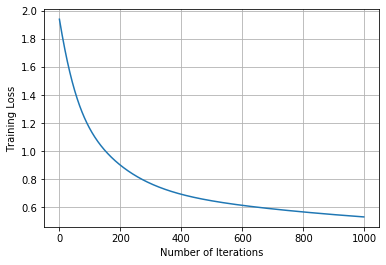

In [85]:
plt.plot(train_loss)
plt.xlabel("Number of Iterations")
plt.ylabel("Training Loss")
plt.grid()
plt.show()

Train Loss vs Number of Iterations Plot

## Model Evaluation

In [75]:
def predict(X_test,final_weights,threshold):
    predictions=sigmoid(np.matmul(X_test,final_weights))
    final_predictions=[]
    for x in predictions:
        if x>=threshold:
            final_predictions.append(1)
        else:
            final_predictions.append(0)
    return final_predictions

In [76]:
predictions=predict(X_test,final_weights,0.5)

In [77]:
##confusion matrix
def get_confusion_matrix(actual,predicted):
    confusion_matrix=np.zeros((2,2))
    for x,y in zip(actual,predicted):
        confusion_matrix[x,y] +=1
    return confusion_matrix
    

In [78]:
confusion_matrix=get_confusion_matrix(y_test,predictions)
confusion_matrix

array([[ 81., 132.],
       [ 64., 283.]])

In [79]:
##accuracy
accuracy=(confusion_matrix[0][0]+confusion_matrix[1][1])/np.sum(confusion_matrix)
accuracy

0.65

In [80]:
##Recall= TP/(TP+FN)
recall=(confusion_matrix[0][0])/(confusion_matrix[0][0]+confusion_matrix[0][1])
recall

0.38028169014084506

In [81]:
##Precision= TP/(TP+FP) is fraction of +ve examples classifier classified as +ve that are actually +ve
precision=(confusion_matrix[0][0])/(confusion_matrix[0][0]+confusion_matrix[1][0])
precision

0.5586206896551724

In [82]:
##F1-Score
f1_score=(2*recall*precision)/(recall+precision)
f1_score

0.45251396648044695

**ROC Curve**

ROC(Receiver Operating Characteristics) Curve is a TPR vs FPR plot at different threshold levels 

In [83]:
TPR=[]
FPR=[]
for threshold in np.arange(0,1,0.1):
    predictions=predict(X_test,final_weights,threshold)
    confusion_matrix=get_confusion_matrix(y_test,predictions)
    true_pos_rate=(confusion_matrix[0][0])/(confusion_matrix[0][0]+confusion_matrix[0][1])
    false_pos_rate=(confusion_matrix[1][0])/(confusion_matrix[1][0]+confusion_matrix[1][1])
    TPR.append(true_pos_rate)
    FPR.append(false_pos_rate)

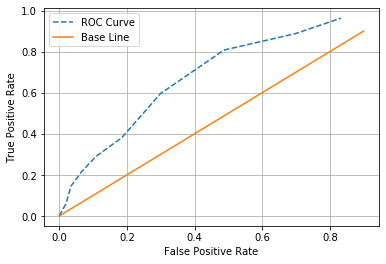

In [84]:
base=np.arange(0,1,0.1)
plt.plot(FPR,TPR,linestyle='--',label='ROC Curve')
plt.plot(base,base,label='Base Line')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid()
plt.show()